In [2]:
import os

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from Bio import SeqIO
import regex as rx

### Setup

In [3]:
lothar = '/home/enno/uni/SS24/thesis/1_RegEx'

In [8]:
if os.getcwd() != lothar:
    input_file = '/ebio/abt1_share/prediction_hendecads/1_repo/1_RegEx/0_data/sequences.fasta'
    clans_file = '/ebio/abt1_share/prediction_hendecads/1_repo/1_RegEx/0_data/new_hendecads_1E-14.clans'
    df = pd.read_csv('/ebio/abt1_share/prediction_hendecads/1_repo/1_RegEx/0_data/regEx.csv')
else:
    input_file = '/home/enno/uni/SS24/thesis/1_RegEx/0_data/sequences.fasta'
    clans_file = '/home/enno/uni/SS24/thesis/1_RegEx/0_data/new_hendecads_1E-14.clans'
    df = pd.read_csv('/home/enno/uni/SS24/thesis/1_RegEx/0_data/regEx_5R.csv')
    
fasta_sequences = list(SeqIO.parse(open(input_file),'fasta'))
n_seq = len(fasta_sequences)

#### Reading Sequences + Repetetive Stretches

In [4]:
# Read .fasta file, extract stretches and store them in a df

df = pd.DataFrame(columns=['id', 'seq', 'stretch_ix', 'stretch_seq'])

pattern = r'\[\[.*?\]\]'

for seq_ix, seq in enumerate(list(SeqIO.parse(open(input_file), 'fasta'))):

    print(f"Processing sequence {seq_ix+1}/{n_seq}", end='\r')
    
    s = str(seq.seq).lower()
    d = str(seq.description)
    
    stretches = eval(rx.findall(pattern, d.split('|||')[-1])[0])

    tmp_six = []
    tmp_seq = []

    for sx, stretch in enumerate(stretches):
                
        cc_ix = [x for x in range(stretch[0], stretch[1]+1)]
        stretch_seq = s[min(cc_ix):max(cc_ix)]

        tmp_six.append(cc_ix)
        tmp_seq.append(stretch_seq)
    
    df.loc[len(df), ] = [seq.id, s, tmp_six, tmp_seq]

#### Reading Cluster Assignments from .clans

In [5]:
def parse_numbers(filename):
    # extracts the cluster assignments from the .clans file

    clusters = []
    with open(filename, 'r') as file:
       
        for line in file:
            
            if rx.match('numbers=', line):
                
                _, num_str = line.split('=')
                numbers = [int(num.strip()) for num in num_str.split(';')[:-1]]

                clusters.append(numbers)
    
    return clusters

In [6]:
numbers = parse_numbers(clans_file)

In [7]:
# assign clusters to sequences

for ix, cluster in enumerate(numbers):
        df.loc[cluster, 'c'] = ix

df.loc[df['c'].isna(), 'c'] = -1

#### Reading CLANS coordinates

In [11]:
with open(clans_file, 'r') as file:
    data = file.readlines()

data = [line.strip() for line in data]

# line positoins in new_hendecads_1E-14.clans
first_pos = 73772
last_pos = 73772 + len(df)

pos = [x.split() for x in data[first_pos:last_pos]]

x = [float(x[1]) for x in pos]
y = [float(x[2]) for x in pos]

df['npf_x'] = x
df['npf_y'] = y

In [10]:
df.to_csv('/home/enno/uni/SS24/thesis/1_RegEx/0_data/regEx.csv', index=False)

### RegEx

In [12]:
def find_match(seq, pattern, i, mm):
    # suffix for fuzzy regex
    mm_suffix = r'{e<=' + str(mm) + '}'
    pattern = r'(' + pattern * i + r')' + mm_suffix

    N = 11 * i  # length of pattern
    i = 0       # running index

    hits = []
    hits_ix = []

    while len(seq) >= N:  # while remaining sequence is longer than pattern

        match = rx.search(pattern, seq[:N])

        if match and len(match.group(0)) == N:  # if match is found and fuzzyness is substitution only, not indel
            hits.append(match.group(0))
            hits_ix.append([i, i+N])

        seq = seq[1:]
        i += 1

    return hits, hits_ix

In [13]:
              # a--d---h---a--d---h---
query_string = 'av1av11av11av2av22av22'

In [14]:
pattern = r'[avilm]..[avilm]...[avilm]...'

find_match(query_string, pattern, 1, 0)

(['av1av11av11', 'v1av11av11a', 'v11av11av2a', 'v11av2av22a', 'av2av22av22'],
 [[0, 11], [1, 12], [4, 15], [8, 19], [11, 22]])

#### Apply to Data

In [17]:
pattern = r'[avilm]..[avilm]...[avilm]...'

def process_row(row, lx, mmx):
    tmp_stretch = [find_match(stretch, pattern, lx, mmx) for stretch in row['stretch_seq']]
    return tmp_stretch

for lx in [5]:  # number of consecutive repeats
    print(lx)
    
    for mmx in range(0, 5): # number of allowed mismatches
        print(mmx)
        df[f'{lx}R_{mmx}MM'] = df.apply(lambda x: process_row(x, lx, mmx), axis=1)

df.to_csv('/home/enno/uni/SS24/thesis/1_RegEx/0_data/regEx_5R.csv', index=False)

5
0
1
2
3
4


In [18]:
col0 = [f'{i}R_0MM' for i in [1, 3, 5, 10]]  # 0 mismatches
col1 = [f'{i}R_1MM' for i in [1, 3, 5, 10]]  # 1 mismatches
col2 = [f'{i}R_2MM' for i in [1, 3, 5, 10]]  # 2 mismatches

fiver_col = [f'5R_{i}MM' for i in range(0, 5)]

# separatae seqs from indices and count number of hits
for col in fiver_col:
    df[f'{col}_seq'] = df[col].apply(lambda x: [item[0] for item in x])
    df[f'{col}_ix'] = df[col].apply(lambda x: [item[1] for item in x])
    df[f'{col}_n'] = df[col].apply(lambda x: sum([1 for stretch in x for hit in stretch[0]]))

In [21]:
df.columns

Index(['id', 'seq', 'stretch_ix', 'stretch_seq', 'c', 'npf_x', 'npf_y',
       '5R_0MM', '5R_1MM', '5R_2MM', '5R_3MM', '5R_4MM', '5R_0MM_seq',
       '5R_0MM_ix', '5R_0MM_n', '5R_1MM_seq', '5R_1MM_ix', '5R_1MM_n',
       '5R_2MM_seq', '5R_2MM_ix', '5R_2MM_n', '5R_3MM_seq', '5R_3MM_ix',
       '5R_3MM_n', '5R_4MM_seq', '5R_4MM_ix', '5R_4MM_n'],
      dtype='object')

In [22]:
# drop col0, col1, col2 since they are now redundant
df.drop(columns=fiver_col, inplace=True)  # col0 + col1 + col2

df.to_csv('/home/enno/uni/SS24/thesis/1_RegEx/0_data/regEx_5R.csv', index=False)

#### Visualize for TMPs

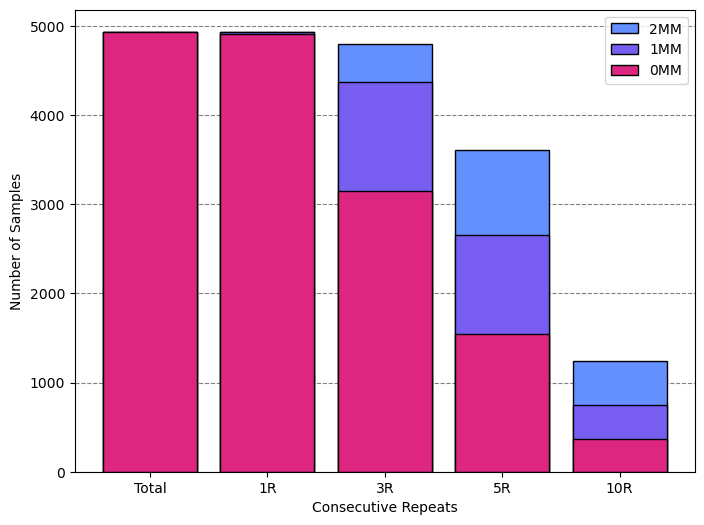

In [8]:
mm = ['4MM', '3MM', '2MM', '1MM', '0MM']
rr = ['5R']  # '1R', '3R', '5R', '10R'

palette = ['#648FFF', '#785EF0', '#DC267F']

fig, ax = plt.subplots(figsize=(8, 6))
plt.grid()

for ix, mx in enumerate(mm):
    
    total_length = len(df[df['c'] == 0])
    length_1R = len(df[(df['c'] == 0) & (df[f'1R_{mx}_n'] > 0)])
    length_3R = len(df[(df['c'] == 0) & (df[f'3R_{mx}_n'] > 0)])
    length_5R = len(df[(df['c'] == 0) & (df[f'5R_{mx}_n'] > 0)])
    length_10R = len(df[(df['c'] == 0) & (df[f'10R_{mx}_n'] > 0)])

    # Create the bar plot
    labels = ['5R']  # ['Total', '1R', '3R', '5R', '10R']
    lengths = [total_length, length_1R, length_3R, length_5R, length_10R]

    plt.bar(labels, lengths, edgecolor='black', label=mx, color=palette[ix])

ax.yaxis.grid(color='gray', linestyle='dashed')
ax.xaxis.grid(False)
ax.set_axisbelow(True)

plt.legend()
plt.xlabel('Consecutive Repeats')
plt.ylabel('Number of Samples')
plt.show()

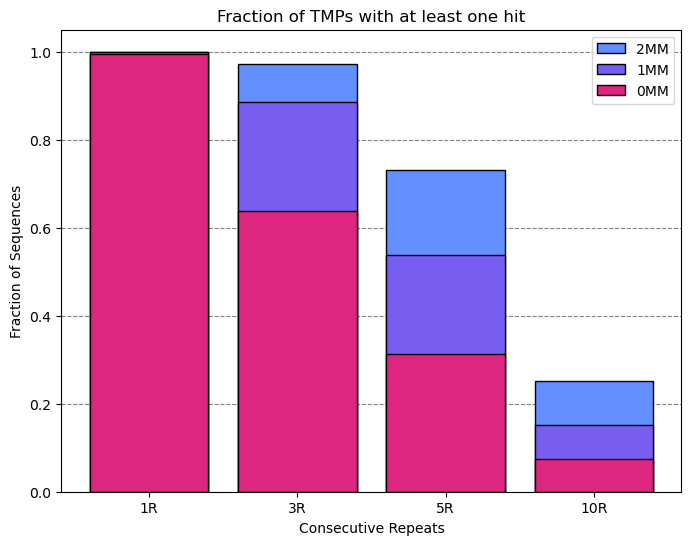

In [11]:
mm = ['2MM', '1MM', '0MM']
rr = ['5R']  # ['1R', '3R', '5R', '10R']

palette = ['#648FFF', '#785EF0', '#DC267F']

fig, ax = plt.subplots(figsize=(8, 6))
plt.grid()

for ix, mx in enumerate(mm):
    
    total_length = len(df[df['c'] == 0])
    length_1R = len(df[(df['c'] == 0) & (df[f'1R_{mx}_n'] > 0)])
    length_3R = len(df[(df['c'] == 0) & (df[f'3R_{mx}_n'] > 0)])
    length_5R = len(df[(df['c'] == 0) & (df[f'5R_{mx}_n'] > 0)])
    length_10R = len(df[(df['c'] == 0) & (df[f'10R_{mx}_n'] > 0)])

    # Create the bar plot
    labels = ['5R']  # ['Total', '1R', '3R', '5R', '10R']
    lengths = [length_1R/total_length, length_3R/total_length, length_5R/total_length, length_10R/total_length]

    plt.bar(labels, lengths, edgecolor='black', label=mx, color=palette[ix])

ax.yaxis.grid(color='gray', linestyle='dashed')
ax.xaxis.grid(False)
ax.set_axisbelow(True)

plt.legend()
plt.title('Fraction of TMPs with at least one hit')
plt.xlabel('Consecutive Repeats')
plt.ylabel('Fraction of Sequences')
plt.show()

In [9]:
lengths = []
for mx in range(0, 5):
    length = len(df[(df['c'] == 0) & (df[f'5R_{mx}MM_n'] > 0)])
    lengths.append(length)

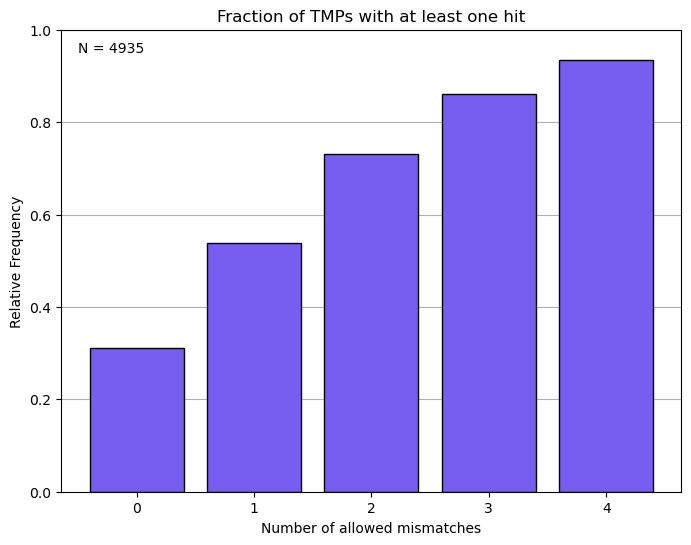

In [32]:
fig, ax = plt.subplots(figsize=(8, 6))

plt.bar(x=list(range(5)), height=np.array(lengths) / len(df[df['c'] == 0]), edgecolor='black', color='#785EF0')

plt.xlabel('Number of allowed mismatches')
plt.ylabel('Relative Frequency')

ax.set_axisbelow(True)
plt.grid(axis='y')
plt.ylim(0, 1)

n_tmp = len(df[df['c'] == 0])
plt.text(-0.5, 0.95, f'N = {n_tmp}')
plt.title('Fraction of TMPs with at least one hit')
plt.show()

#### Write Repeats and MM to .fasta

In [31]:
test_seq = df.iloc[74]
col = '1R_0MM_seq'

for stretch_ix, stretch in enumerate(test_seq[col]):
    for seq_ix, seq in enumerate(stretch):

        print(f'>{test_seq["id"]}_{col}_stretch_{stretch_ix}_seq_{seq_ix}')

>XP_019958182.1_1R_0MM_seq_stretch_1_seq_0
>XP_019958182.1_1R_0MM_seq_stretch_1_seq_1
>XP_019958182.1_1R_0MM_seq_stretch_1_seq_2
>XP_019958182.1_1R_0MM_seq_stretch_1_seq_3


In [30]:
for mm in [0, 1, 2, 3, 4]:
    for col in [f'5R_{mm}MM_seq']:  # [f'1R_{mm}MM_seq', f'3R_{mm}MM_seq', f'5R_{mm}MM_seq', f'10R_{mm}MM_seq']:
        tmp_df = df[(df[col[:-4] + '_n'] > 0) & (df['c'] == 0)].reset_index(drop=True)

        with open(f'/home/enno/uni/SS24/thesis/1_RegEx/0_data/fasta_5R/{col}.fasta', 'w') as file:

            for seq_ix, seq in enumerate(tmp_df[col]):
                for stretch_ix, stretch in enumerate(seq):
                    for hit_ix, hit in enumerate(stretch):

                        file.write(f'>{tmp_df.iloc[seq_ix]["id"]}_{col}_stretch_{stretch_ix}_seq_{hit_ix}\n')
                        file.write(f'{hit.upper()}\n')